In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

In [42]:
%watermark -n -u -v -iv -w

Last updated: Sat Jun 04 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.3.0

matplotlib: 3.5.2
pandas    : 1.4.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
scipy     : 1.7.3
numpy     : 1.22.4
arviz     : 0.12.1
pymc      : 4.0.0b1

Watermark: 2.3.0



In [3]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


arviz doesn't speak pandas??

In [4]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
height,138.264,27.602,81.585,172.999
weight,35.611,14.719,7.201,55.282
age,29.344,20.747,0.000,65.300
male,0.472,0.500,0.000,1.000


In [5]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [6]:
d2 = d[d.age >= 18]
az.summary(d2.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
height,154.597,7.742,139.700,167.005
weight,44.990,6.457,34.189,57.068
age,41.138,15.968,18.000,69.000
male,0.469,0.500,0.000,1.000


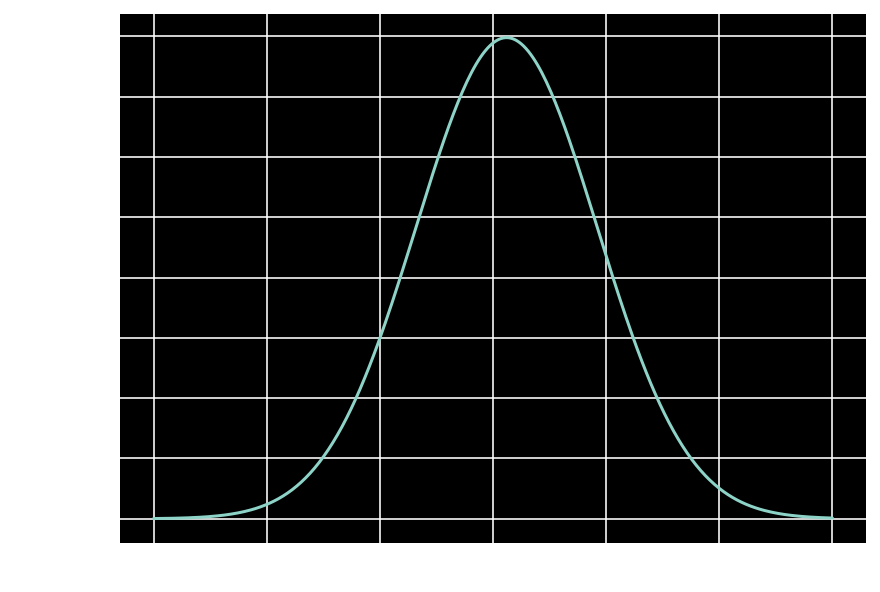

In [7]:
x = np.linspace(100,250,300)
plt.plot(x, stats.norm.pdf(x, 178, 20))

<AxesSubplot:>

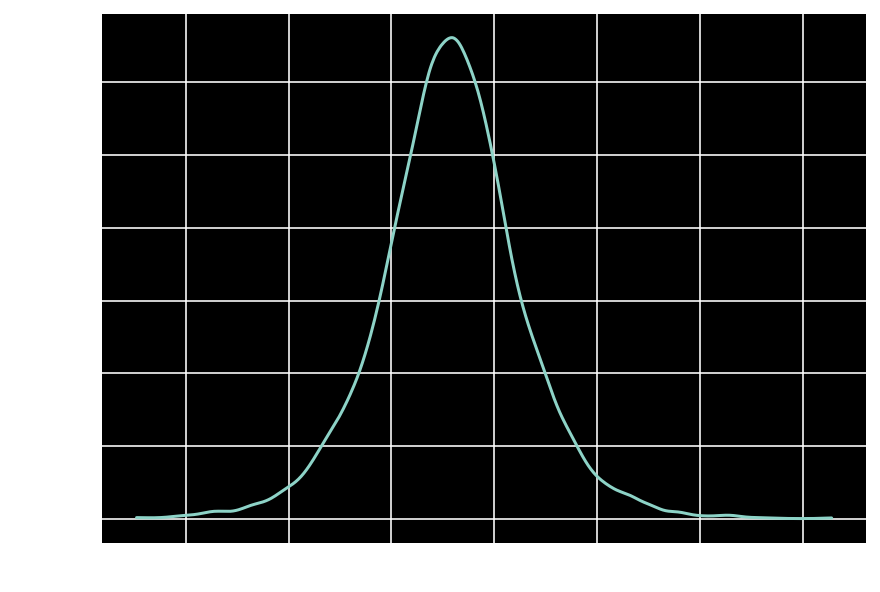

In [8]:
sample_mu_prior = stats.norm.rvs(178,20,10000)
sample_s_prior = stats.uniform.rvs(0,50,10000)
#sample_s_prior = stats.expon.rvs(scale=1,size=10000)
prior_predictive = stats.norm.rvs(sample_mu_prior, sample_s_prior)
az.plot_kde(prior_predictive)

making a 2d grid

In [9]:
a = np.mgrid[1:2.5:0.5, 1:3.4:0.4].reshape(2,-1).T

#2nd for is the inner loop
b = np.array([x+y for x in np.linspace(1,2,3) for y in np.linspace(1,3,6)])
#so this outputs all the x's for each y
b2 = np.array([x+y for y in np.linspace(1,3,6) for x in np.linspace(1,2,3)])
#so when you reshape, x's are columns and y's are rows
#  note: shape is (rows, cols)
b2d = np.reshape(b2,(6,3))

## manual 2d with x cols and y rows
##  note: transpose for [x,y] indexing, which is [row, col]
c = np.array([[x+y for x in np.linspace(1,2,3)] for y in np.linspace(1,3,6)])

np.equal(b2d,c)


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

in plot.contour, X is columns and Y is rows

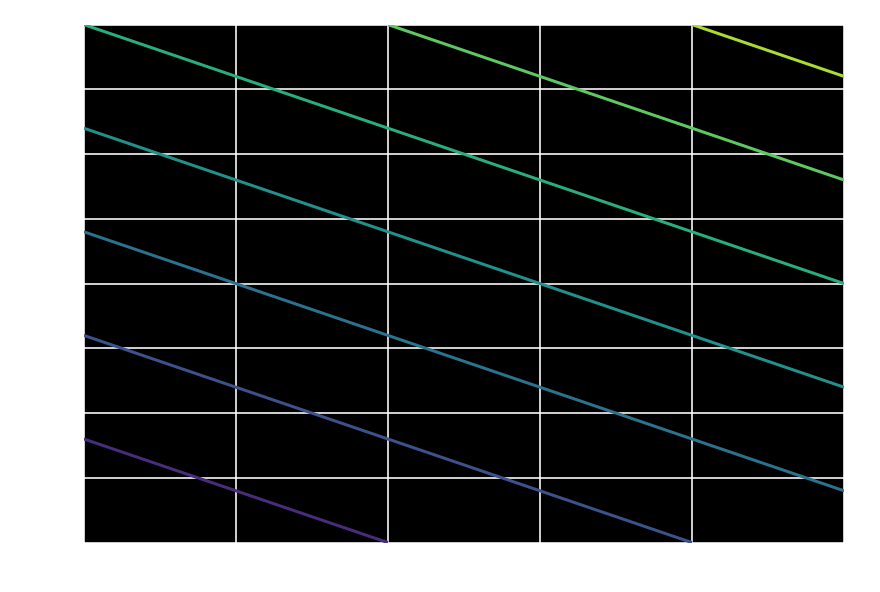

In [10]:
plt.contour(np.linspace(1,2,3), np.linspace(1,3,6), b2d)

product of all the data likelihoods at a given mu and sigma

In [11]:
heights = np.array(d2.height)
def total_nLL(data, mu, sigma):
    return sum(stats.norm.logpdf(data, loc=mu, scale=sigma))

mu_grid = np.linspace(150,160,400)
s_grid = np.linspace(7,9,200)
#LL = np.array([ [total_nLL(d2.height, m, s) for m in mu_grid] for s in s_grid])
LL = np.array([total_nLL(heights, m, s) for s in s_grid for m in mu_grid])


prior grid

In [12]:

def prior_prob(mu, sigma):
    return stats.norm.logpdf(mu, loc=178, scale=20) + stats.uniform.logpdf(sigma, loc=0, scale=50)

#Lprior = np.array([[ prior_prob(m,s) for m in mu_grid] for s in s_grid])
Lprior = np.array([ prior_prob(m,s) for s in s_grid for m in mu_grid])


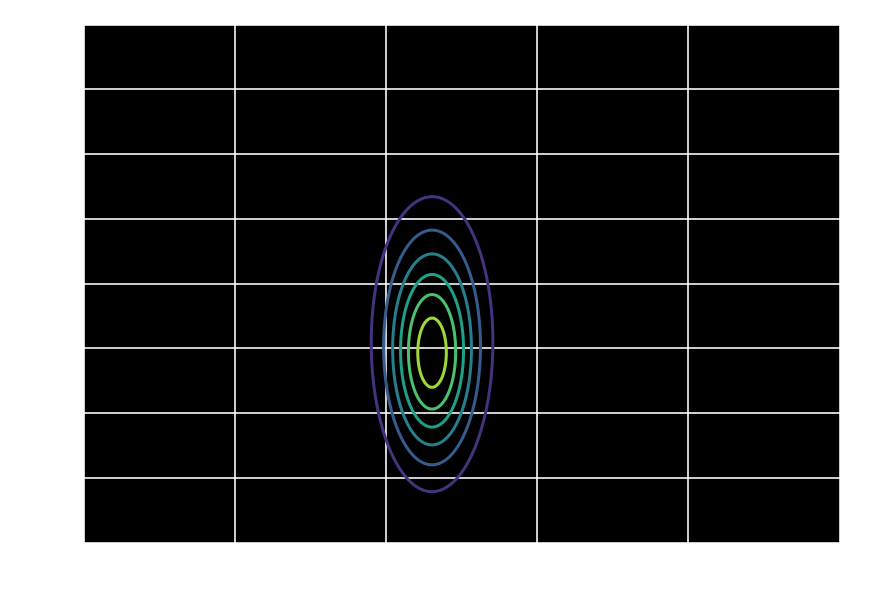

In [13]:
post_log = LL + Lprior
pos = np.exp(post_log - np.max(post_log))

pos2d = np.reshape(pos, (200,400))

plt.contour(mu_grid, s_grid, pos2d)

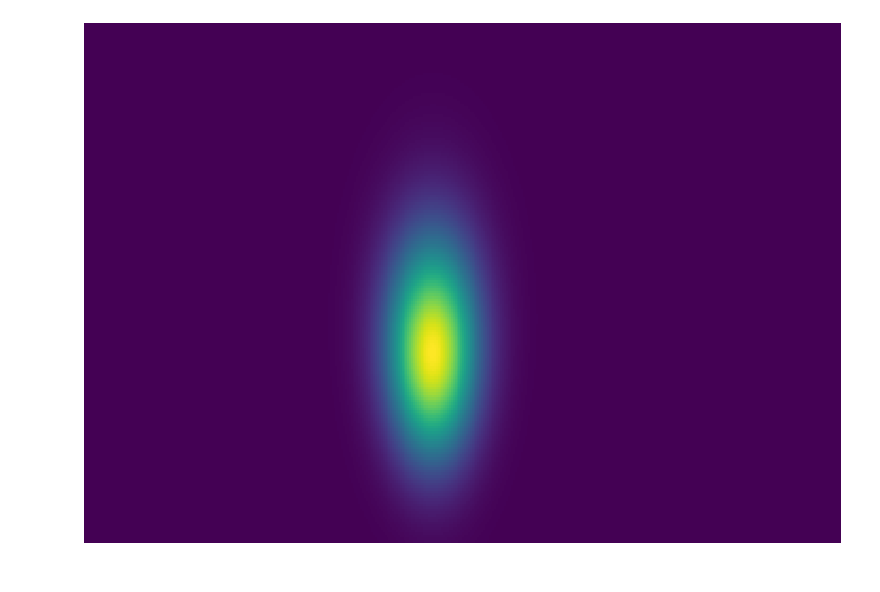

In [14]:
_, ax = plt.subplots()
ax.pcolormesh(mu_grid,s_grid,pos2d)

sampling from the posterior

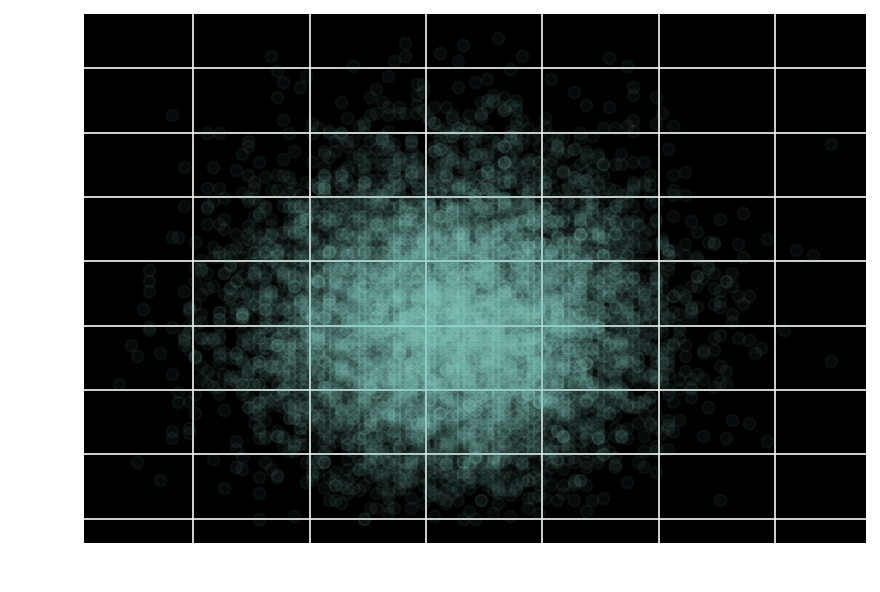

In [15]:

param_combos = np.array([ (m,s) for s in s_grid for m in mu_grid])
posp = pos/np.sum(pos)

## note: numpy doesn't understand tuples
sample = param_combos[np.random.choice(len(param_combos), size=10000, replace=True, p=posp)]
sample_mu = sample[:,0]
sample_sigma = sample[:,1]
plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)


<AxesSubplot:>

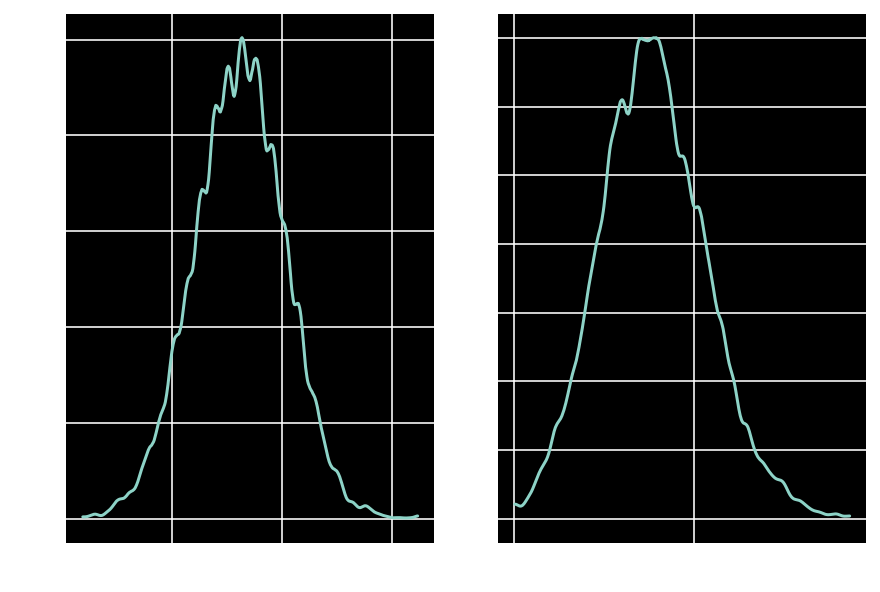

In [16]:
_, ax = plt.subplots(1,2)
az.plot_kde(sample_mu, ax=ax[0])
az.plot_kde(sample_sigma, ax=ax[1])

In [17]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.85964912, 155.38847118]), array([7.21105528, 8.30653266]))

PyMC

In [18]:
with pm.Model() as m4_1:
    m = pm.Normal("mu", mu=178, sd=20)
    s = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=m, sd=s, observed=heights)

In [19]:
with m4_1:
    trace4_1 = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

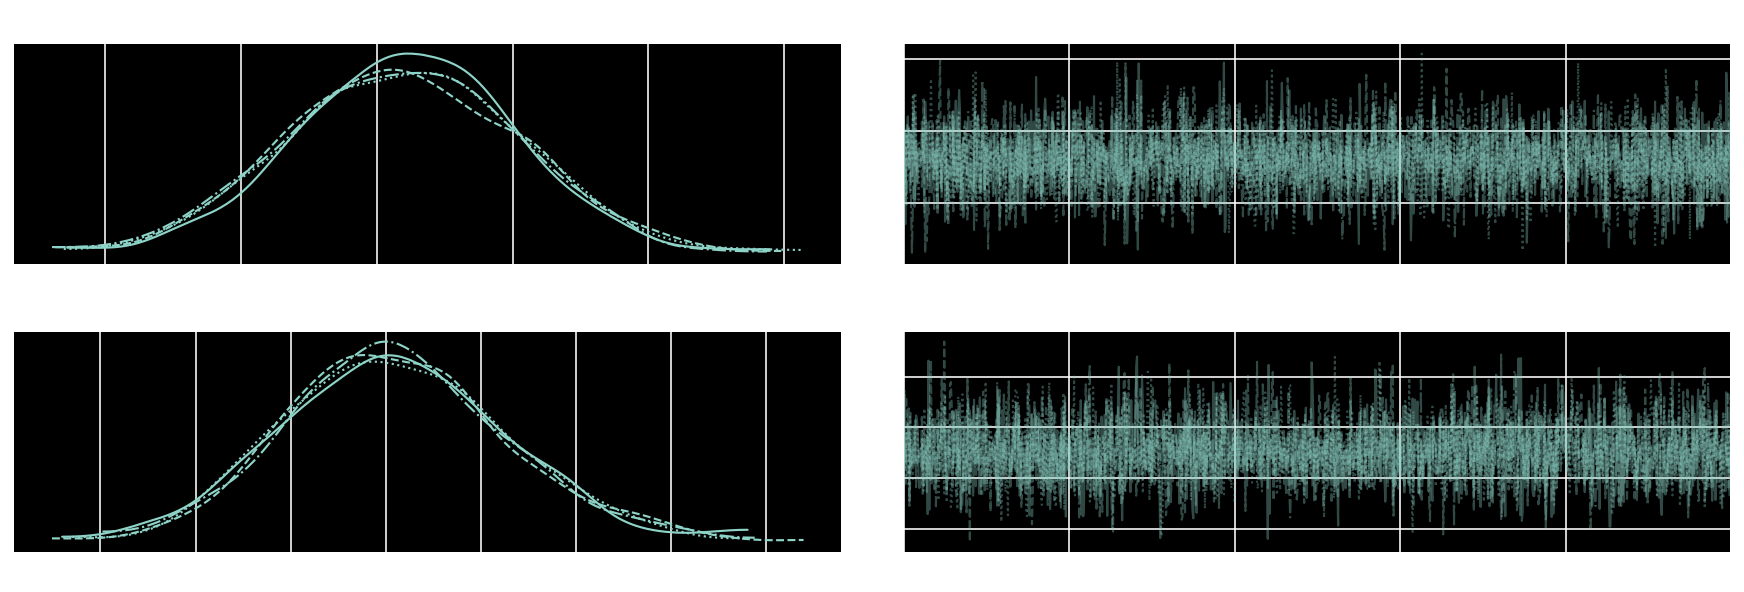

In [20]:
az.plot_trace(trace4_1)

summarizes the posterior samples

In [21]:
az.summary(trace4_1, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,154.60,0.42,153.80,155.36
sigma,7.78,0.29,7.21,8.31


In [22]:
#samples can be accessed in the trace object
trace4_1["posterior"]["sigma"][0][0:10]

<xarray.DataArray 'sigma' (draw: 10)>
array([7.90411485, 7.74750454, 7.78036762, 7.94346596, 7.52230599,
       8.03683775, 7.96690804, 7.91540497, 7.55309664, 7.70381244])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

ch 4.4 Linear Prediction

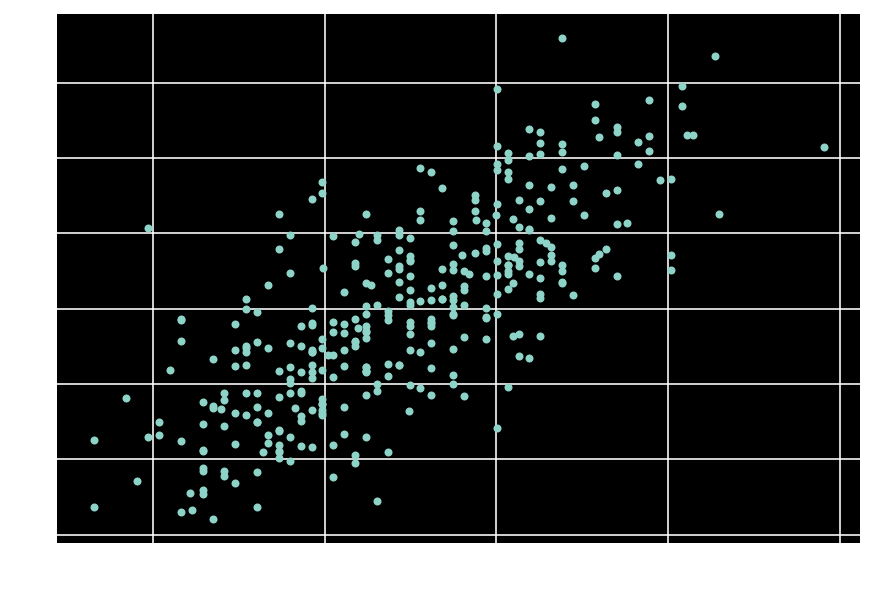

In [23]:
weights = np.array(d2.weight)
plt.plot(heights,weights,".");

Prior predictive

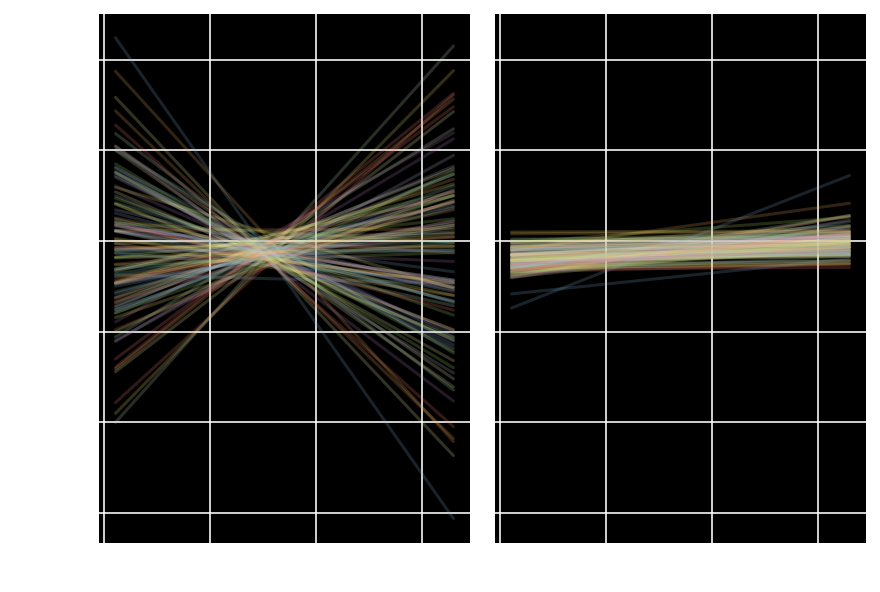

In [24]:
N = 100
a = stats.norm.rvs(178,20,N)
b_norm = stats.norm.rvs(0, 10, N)
b_lnorm = stats.lognorm.rvs(s=1, scale=1, size=N)

x = np.linspace(np.min(weights), np.max(weights), 100)
xbar = np.mean(weights)

_, ax = plt.subplots(1,2, sharey=True)
for i in range(N):
    ax[0].plot(x, a[i] + b_norm[i]*(x - xbar), alpha=0.2)
    ax[1].plot(x, a[i] + b_lnorm[i]*(x - xbar), alpha=0.2)

In [25]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.LogNormal("b", mu=0, sd=1)
    #same as
    #log_b = pm.Normal("log_b", mu=0, sd=1)
    s = pm.Uniform("s", 0, 50)
    mu = a + b * (weights - xbar)
    #same as
    #mu = a + np.exp(log_b) * (weights - xbar)
    height = pm.Normal("height", mu=mu, sd=s, observed=heights)
    trace4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [26]:
az.summary(trace4_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,154.601,0.280,154.074,155.110
b,0.903,0.042,0.827,0.983
s,5.107,0.196,4.747,5.475


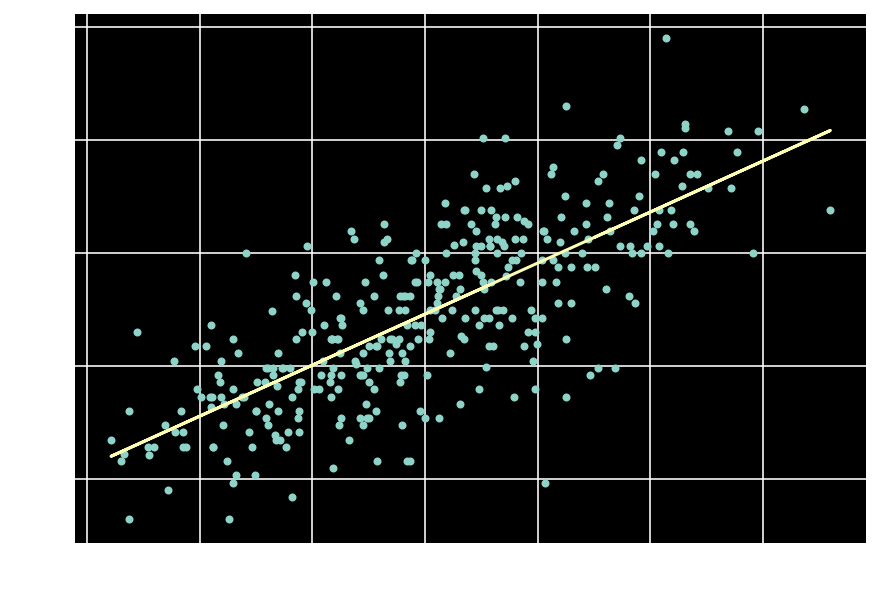

In [27]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(d2.weight, float(np.mean(trace4_3["posterior"]["a"])) + float(np.mean(trace4_3["posterior"]["b"])) * (weights-xbar))


In [28]:
N = [10, 50, 150, 352]
trace_N = []

for x in N:
    dN = d2[0:x]
    weights, heights = np.array(dN.weight), np.array(dN.height)
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sd=20)
        b = pm.LogNormal("b", mu=0, sd=1)
        s = pm.Uniform("s", 0, 50)
        mu = pm.Deterministic("mu", a + b*(weights-weights.mean()))
        height = pm.Normal("height", mu=mu, sd=s, observed=heights)
        trace_N.append(pm.sample(1000, tune=1000));


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been 

/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been 

/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sasha/miniforge3/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been 

/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/sasha/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


sampling from the posterior

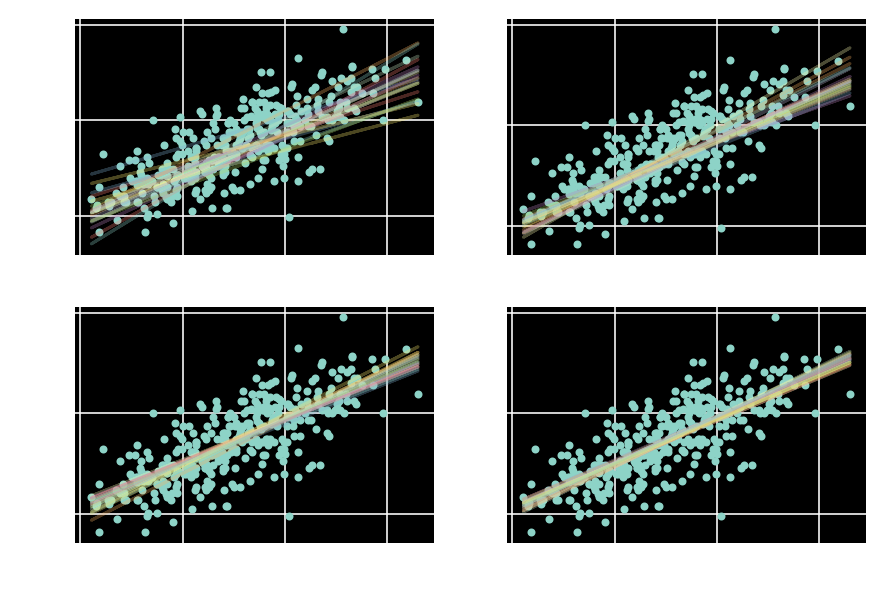

In [29]:
#exd = az.extract_dataset(trace_N)
#exd["a"]

## easier sampling
#tod = trace_N.to_dataframe()

_, ax = plt.subplots(2,2)

for idx, t in enumerate(trace_N):
    tod = t.to_dataframe()
    nsamps = 20
    x = tod.sample(nsamps, replace=True, ignore_index=True)

    a_samples = np.array(x[("posterior", "a")])
    b_samples = np.array(x[("posterior", "b")])

    ax[idx//2, idx%2].plot(weights,heights,".")
    for i in range(nsamps):
        ax[idx//2, idx%2].plot(weights, a_samples[i] + b_samples[i] * (weights - weights.mean()), alpha = 0.3)



[158.4747956  159.78450465]


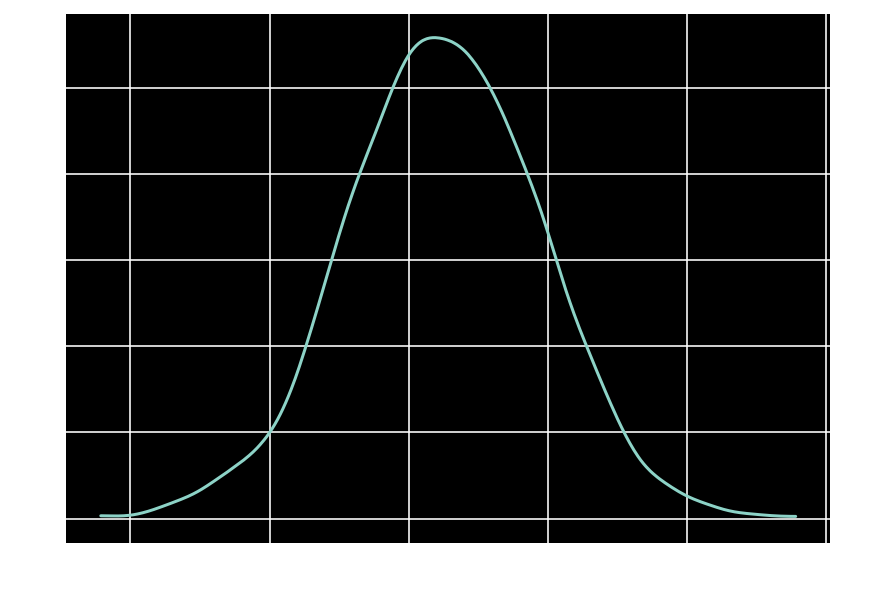

In [30]:
t43data = az.extract_dataset(trace4_3)

a_samp = np.array(t43data["a"])
b_samp = np.array(t43data["b"])

mu_at_50 = a_samp + b_samp*(50 - weights.mean())

az.plot_kde(mu_at_50)
print(az.hdi(mu_at_50))

In [31]:
weight_seq = np.arange(25,71)
m = []

for w in weight_seq:
     m.append(a_samp + b_samp*(w - weights.mean()))

mu_pred = np.array(m)
np.shape(mu_pred)

(46, 4000)

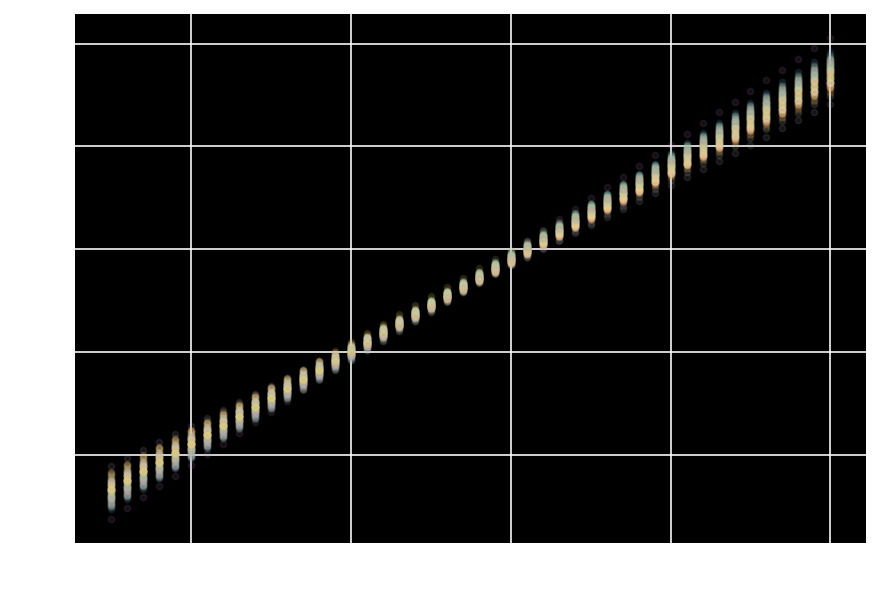

In [32]:
plt.plot(weight_seq,mu_pred[:,0:100],".",alpha=0.1);


(46, 2)


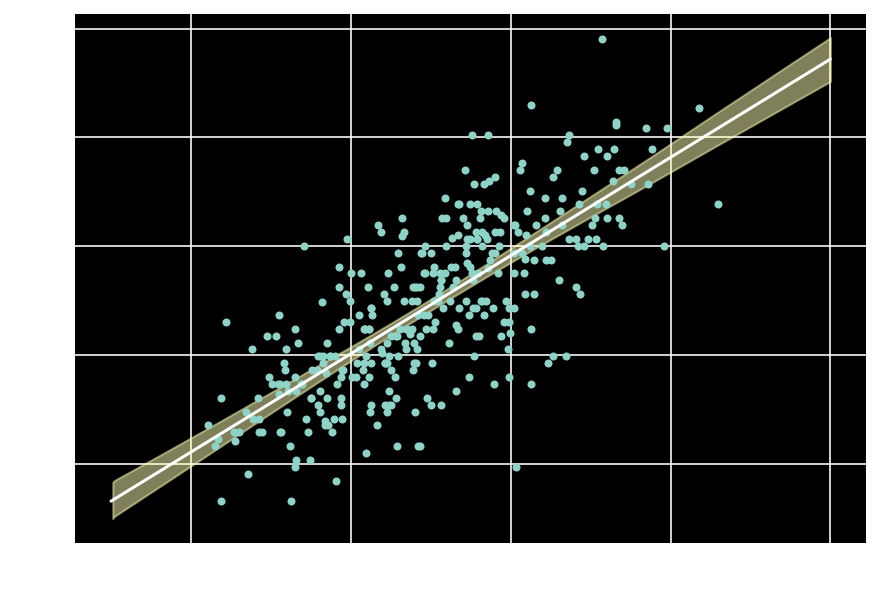

In [33]:
mu_mean = np.mean(mu_pred,1)
mu_hdi = np.array([az.hdi(row) for row in mu_pred])
print(np.shape(mu_hdi))
az.plot_hdi(weight_seq, hdi_data=mu_hdi)
plt.plot(weights,heights, ".")
plt.plot(weight_seq, mu_mean, "w")

posterior predictive: built-in to pymc
 
 note: this treats the likelihood function in model 4_3 as generative

In [34]:
h_pred = pm.sample_posterior_predictive(trace4_3, 1000, m4_3)


/var/folders/8p/pvxyj07903v98z897cyy14cm0000gp/T/ipykernel_76581/1941486676.py:1: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  h_pred = pm.sample_posterior_predictive(trace4_3, 1000, m4_3)


In [35]:
h_pred["posterior_predictive"]["height"]

h_pred.posterior_predictive.height


<xarray.DataArray 'height' (chain: 1, draw: 1000, height_dim_0: 352)>
array([[[162.51663621, 133.64785232, 143.7968292 , ..., 160.62147385,
         163.75266343, 162.485419  ],
        [157.03883466, 142.10850125, 146.66145623, ..., 163.1579453 ,
         158.85657749, 162.99438396],
        [157.66743081, 150.33932763, 142.66942868, ..., 159.99502875,
         151.55050058, 166.06384012],
        ...,
        [163.54147171, 151.41315153, 144.84405561, ..., 160.8230516 ,
         159.5833121 , 155.94223064],
        [156.88406743, 141.83478714, 140.79641103, ..., 159.92027558,
         155.44354778, 158.61837492],
        [164.3801976 , 150.66861565, 137.13104341, ..., 165.31612885,
         153.72220172, 152.8390001 ]]])
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * height_dim_0  (height_dim_0) int64 0 1 2 3 4 5 6 ... 346 347 348 349 350 351

In [36]:
hpred_hdi = az.hdi(h_pred["posterior_predictive"]["height"])


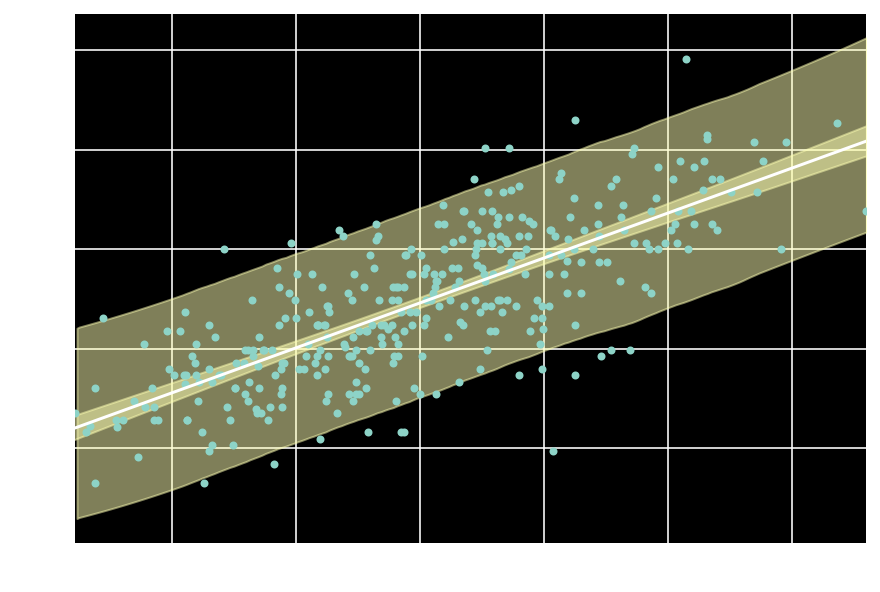

In [37]:
plt.xlim(d2.weight.min(), d2.weight.max())
az.plot_hdi(weight_seq, hdi_data=mu_hdi)
az.plot_hdi(weights, hdi_data=hpred_hdi)
plt.plot(weights,heights, ".")
plt.plot(weight_seq, mu_mean, "w");


manually simulating posterior predictions using the model's likelihood fn

In [38]:
t43df = trace4_3.to_dataframe()
nsamps = 1000
x = t43df.sample(nsamps, replace=True, ignore_index=True)

h = []

a_samples = np.array(x[("posterior", "a")])
b_samples = np.array(x[("posterior", "b")])
sig_samples = np.array(x[("posterior", "s")])

for w in weight_seq:
    mu_samp = a_samples + b_samples * (w - weights.mean())
    h.append(np.random.normal(mu_samp, sig_samples))

height_samp = np.array(h)
np.shape(height_samp)


(46, 1000)

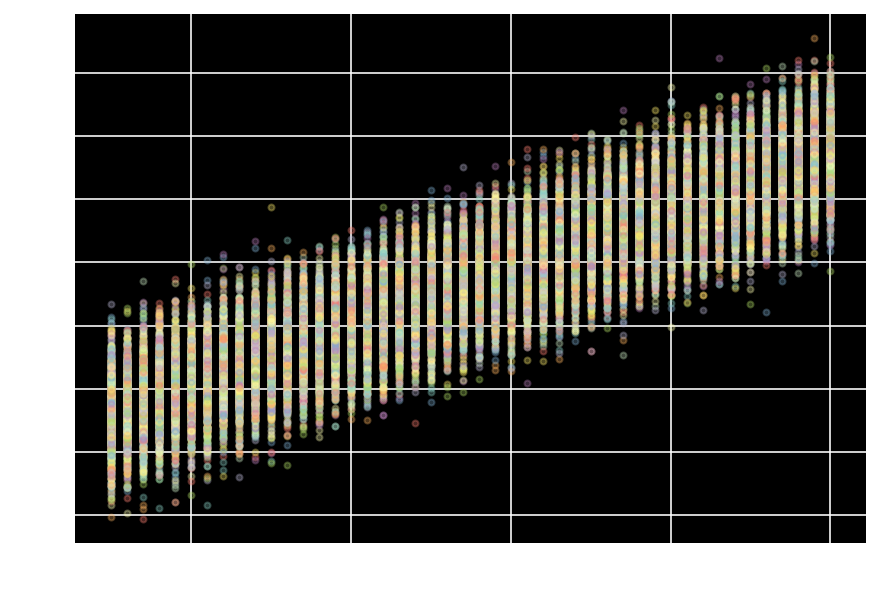

In [39]:
plt.plot(weight_seq, height_samp, ".", alpha=0.3);

In [40]:

h_hdi = np.array([az.hdi(row) for row in height_samp])
#or
#h_hdi = az.hdi(height_samp.T)
np.shape(h_hdi)

(46, 2)

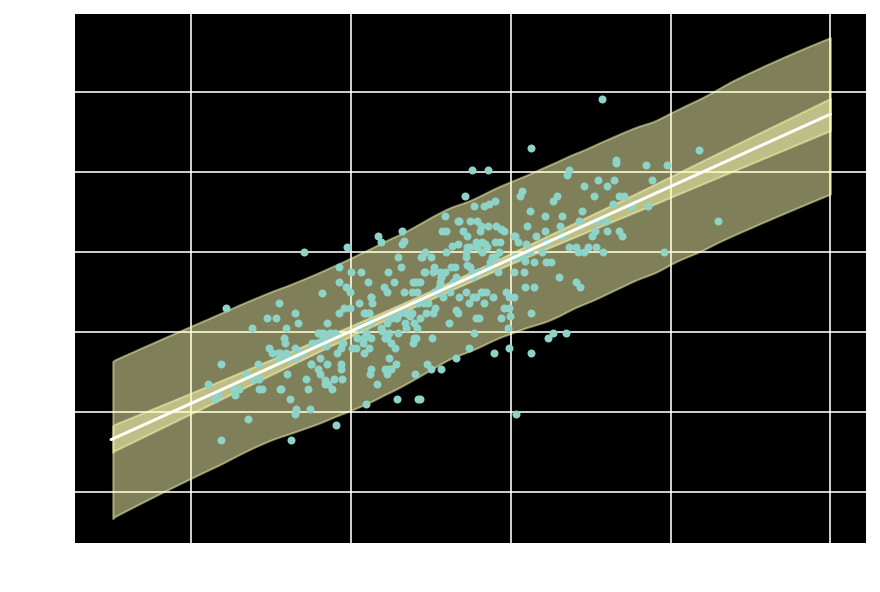

In [41]:
ax= az.plot_hdi(weight_seq, hdi_data=mu_hdi)
az.plot_hdi(weight_seq, hdi_data=h_hdi , ax=ax)
plt.plot(weights,heights, ".")
plt.plot(weight_seq, mu_mean, "w");